# Image processing pipeline - tuned on library

In [18]:
# Import necessary packages
#%pip install imutils opencv-python simplekml palettable gdown
import helper_functions as hf
import plotting as pl
import stitching as st
import gdown
import os
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
from skimage.measure import block_reduce
import cv2
import imageio
import imutils
from palettable import colorbrewer
from scipy import ndimage
from collections import Counter
cv2.ocl.setUseOpenCL(False)

In [2]:
# Variables
gdrive = False # Download data from google drive
link = 'https://drive.google.com/file/d/1IUIAgR7p-RBC8_UzkbhMlKweXaQEek8x/view?usp=sharing'
#'https://drive.google.com/file/d/1ANJ_Hq3C42Zfka_wIDX7wgbH_hwcUbGn/view?usp=sharing' # gdrive link
imgDir = 'data/lsm/Flight 1 - Library/thermal-data/' # Local directory to images
imageType, cmap = False, colorbrewer.get_map('RdYlBu', 'diverging', 11, reverse=True).mpl_colormap # True if RGB images, False if numpy arrays. Choose matplotlib cmap for thermal
pathFile = 'data/lsm/Flight 1.csv' # Flight path .csv file
outName = 'library'
utcDiff = -1 # Time difference to UTC (-1 for BST)
pathColumns = ['timestamp','latitude','longitude','altitude(m)','pitch(deg)','roll(deg)','yaw(deg)'] # Columns used from the path file
filters = ['altitude(m)', 'timestamp'] # Altitude criteria for using imagery
filtValues = [[119.7, 120.3], [1619811011923,1619811099149]]
utmZone, hemisphere = '31n', 'north' # Specify UTM coordinate zone
resolution = 6 # Other resolution for plots
useCentre = True # True if only using center of images
skip = 20 # Plot every nth image for path
height = 120 # Height of camera
fov, pixels = 69, 640 # Long axis field of view and number of pixels of camera
pxSize = (height*np.tan(np.deg2rad(fov/2)))/(pixels/2) # Specify pixel size (m) - for now

In [3]:
# Download from google drive if gdrive is True
#%capture
if gdrive: 
    zippath = imgDir[:-1]+'.zip'
    downLink = link.split('/d/')[1].split('/view')[0]
    ! gdown -O $zippath 'https://drive.google.com/uc?export=download&id='$downLink
    ! unzip $zippath -d $imgDir
    ! rm $zippath

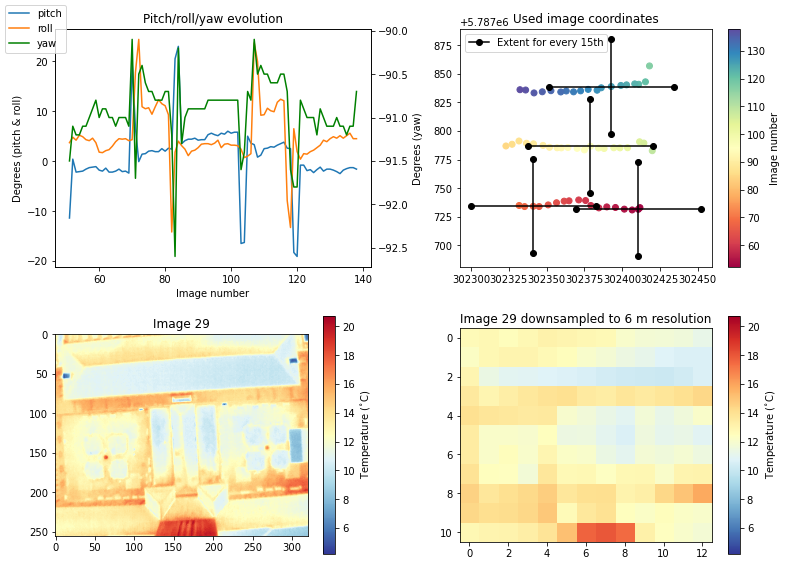

In [4]:
# Create dataframe of images associated with flight information
merged = hf.img_info_merge(imgDir, pathFile, utcDiff, pathColumns, imageType)
merged = hf.filter_imgs(merged, filters, filtValues)
merged, myProj = hf.reproject_coords(merged, utmZone, hemisphere)
idf = hf.correct_coords(merged, 20)

# Plot summary of flight and example image
fig, axs = plt.subplots(2,2,figsize=[11,8])
fig, axs[0,0] = pl.plot_orientation(fig, axs[0,0], merged) 
xq, yq, xCoords, yCoords = hf.use_centre(useCentre, idf, pxSize)
fig, axs[0,1] = pl.plot_route(fig, axs[0,1], idf, xq, yq, pxSize)
fig, axs[1,0] = pl.plot_image(fig, axs[1,0], idf, xq, yq, pxSize, pxSize, cmap, imageType=imageType)
fig, axs[1,1] = pl.plot_image(fig, axs[1,1], idf, xq, yq, pxSize, resolution, cmap, imageType=imageType)
fig.tight_layout()
plt.show()

Images processed: 58it [00:03, 18.91it/s]


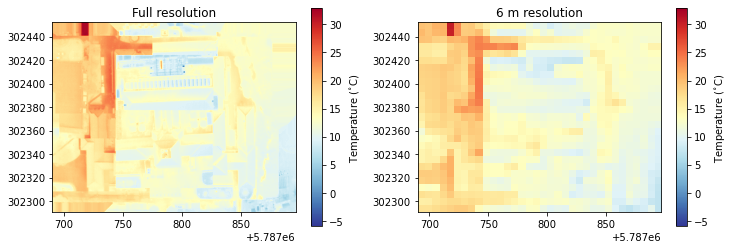

In [5]:
# Stitch images based on xy coordinates
xygrid, extent = st.img_xymerge(idf, xCoords, yCoords, xq, yq, pxSize, imageType=imageType)

# Plot output and downsample
fig, axs = plt.subplots(1,2,figsize=[12,4])
fig, axs[0] = pl.plot_array(fig, axs[0], xygrid, extent, cmap=cmap, title='Full resolution', imageType=imageType)
fig, axs[1] = pl.plot_array(fig, axs[1], hf.downsample_arr(xygrid,pxSize,resolution), extent, cmap=cmap, title=str(resolution)+' m resolution', imageType=imageType, scale=xygrid)

In [14]:
def plot_kml(arr, conv, name, pixels, rot=False, scale=False):
    fig, ax = pl.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                            urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                            pixels=pixels)
    if len(arr.shape) > 2: arr = arr.mean(axis=2)
    if rot is not False: arr = np.ma.masked_where(ndimage.rotate(arr, rot)<1e-2, ndimage.rotate(arr, rot))
    #single = rot < 1e-1, rot)/255*40-10
    single = arr
    if scale is False: scale = single
    cs = ax.imshow(single,extent=(conv[0].min(),conv[0].max(),conv[1].min(),conv[1].max()), cmap=cmap, vmin=scale.min(),vmax=scale.max())
    ax.set_axis_off()
    fig.savefig(name+'.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)
    return cs, single
    
def plot_kml_legend(cs, name, label='Temperature ($^{\circ}$C)'):
    fig = plt.figure(figsize=(1.0, 4.0))
    ax = fig.add_axes([0.07, 0.05, 0.27, 0.9])
    cb = fig.colorbar(cs, cax=ax)
    cb.set_label(label, rotation=-90, color='k', labelpad=20, fontsize=13)
    fig.tight_layout()
    fig.savefig(name+'.png', format='png', bbox_inches = 'tight', pad_inches = 0.2)
    
def plot_kml_path(df, conv, name, pixels, bounds=False):
    if bounds is not False: x, y = df.longitude[bounds[0]:bounds[1]], df.latitude[bounds[0]:bounds[1]]
    else: x,y = df.longitude, df.latitude
    fig, ax = pl.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                             urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                             pixels=pixels)
    ax.plot(x,y,'k-',linewidth=2,label='raw')
    ax.set_axis_off()
    fig.savefig(name+'.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


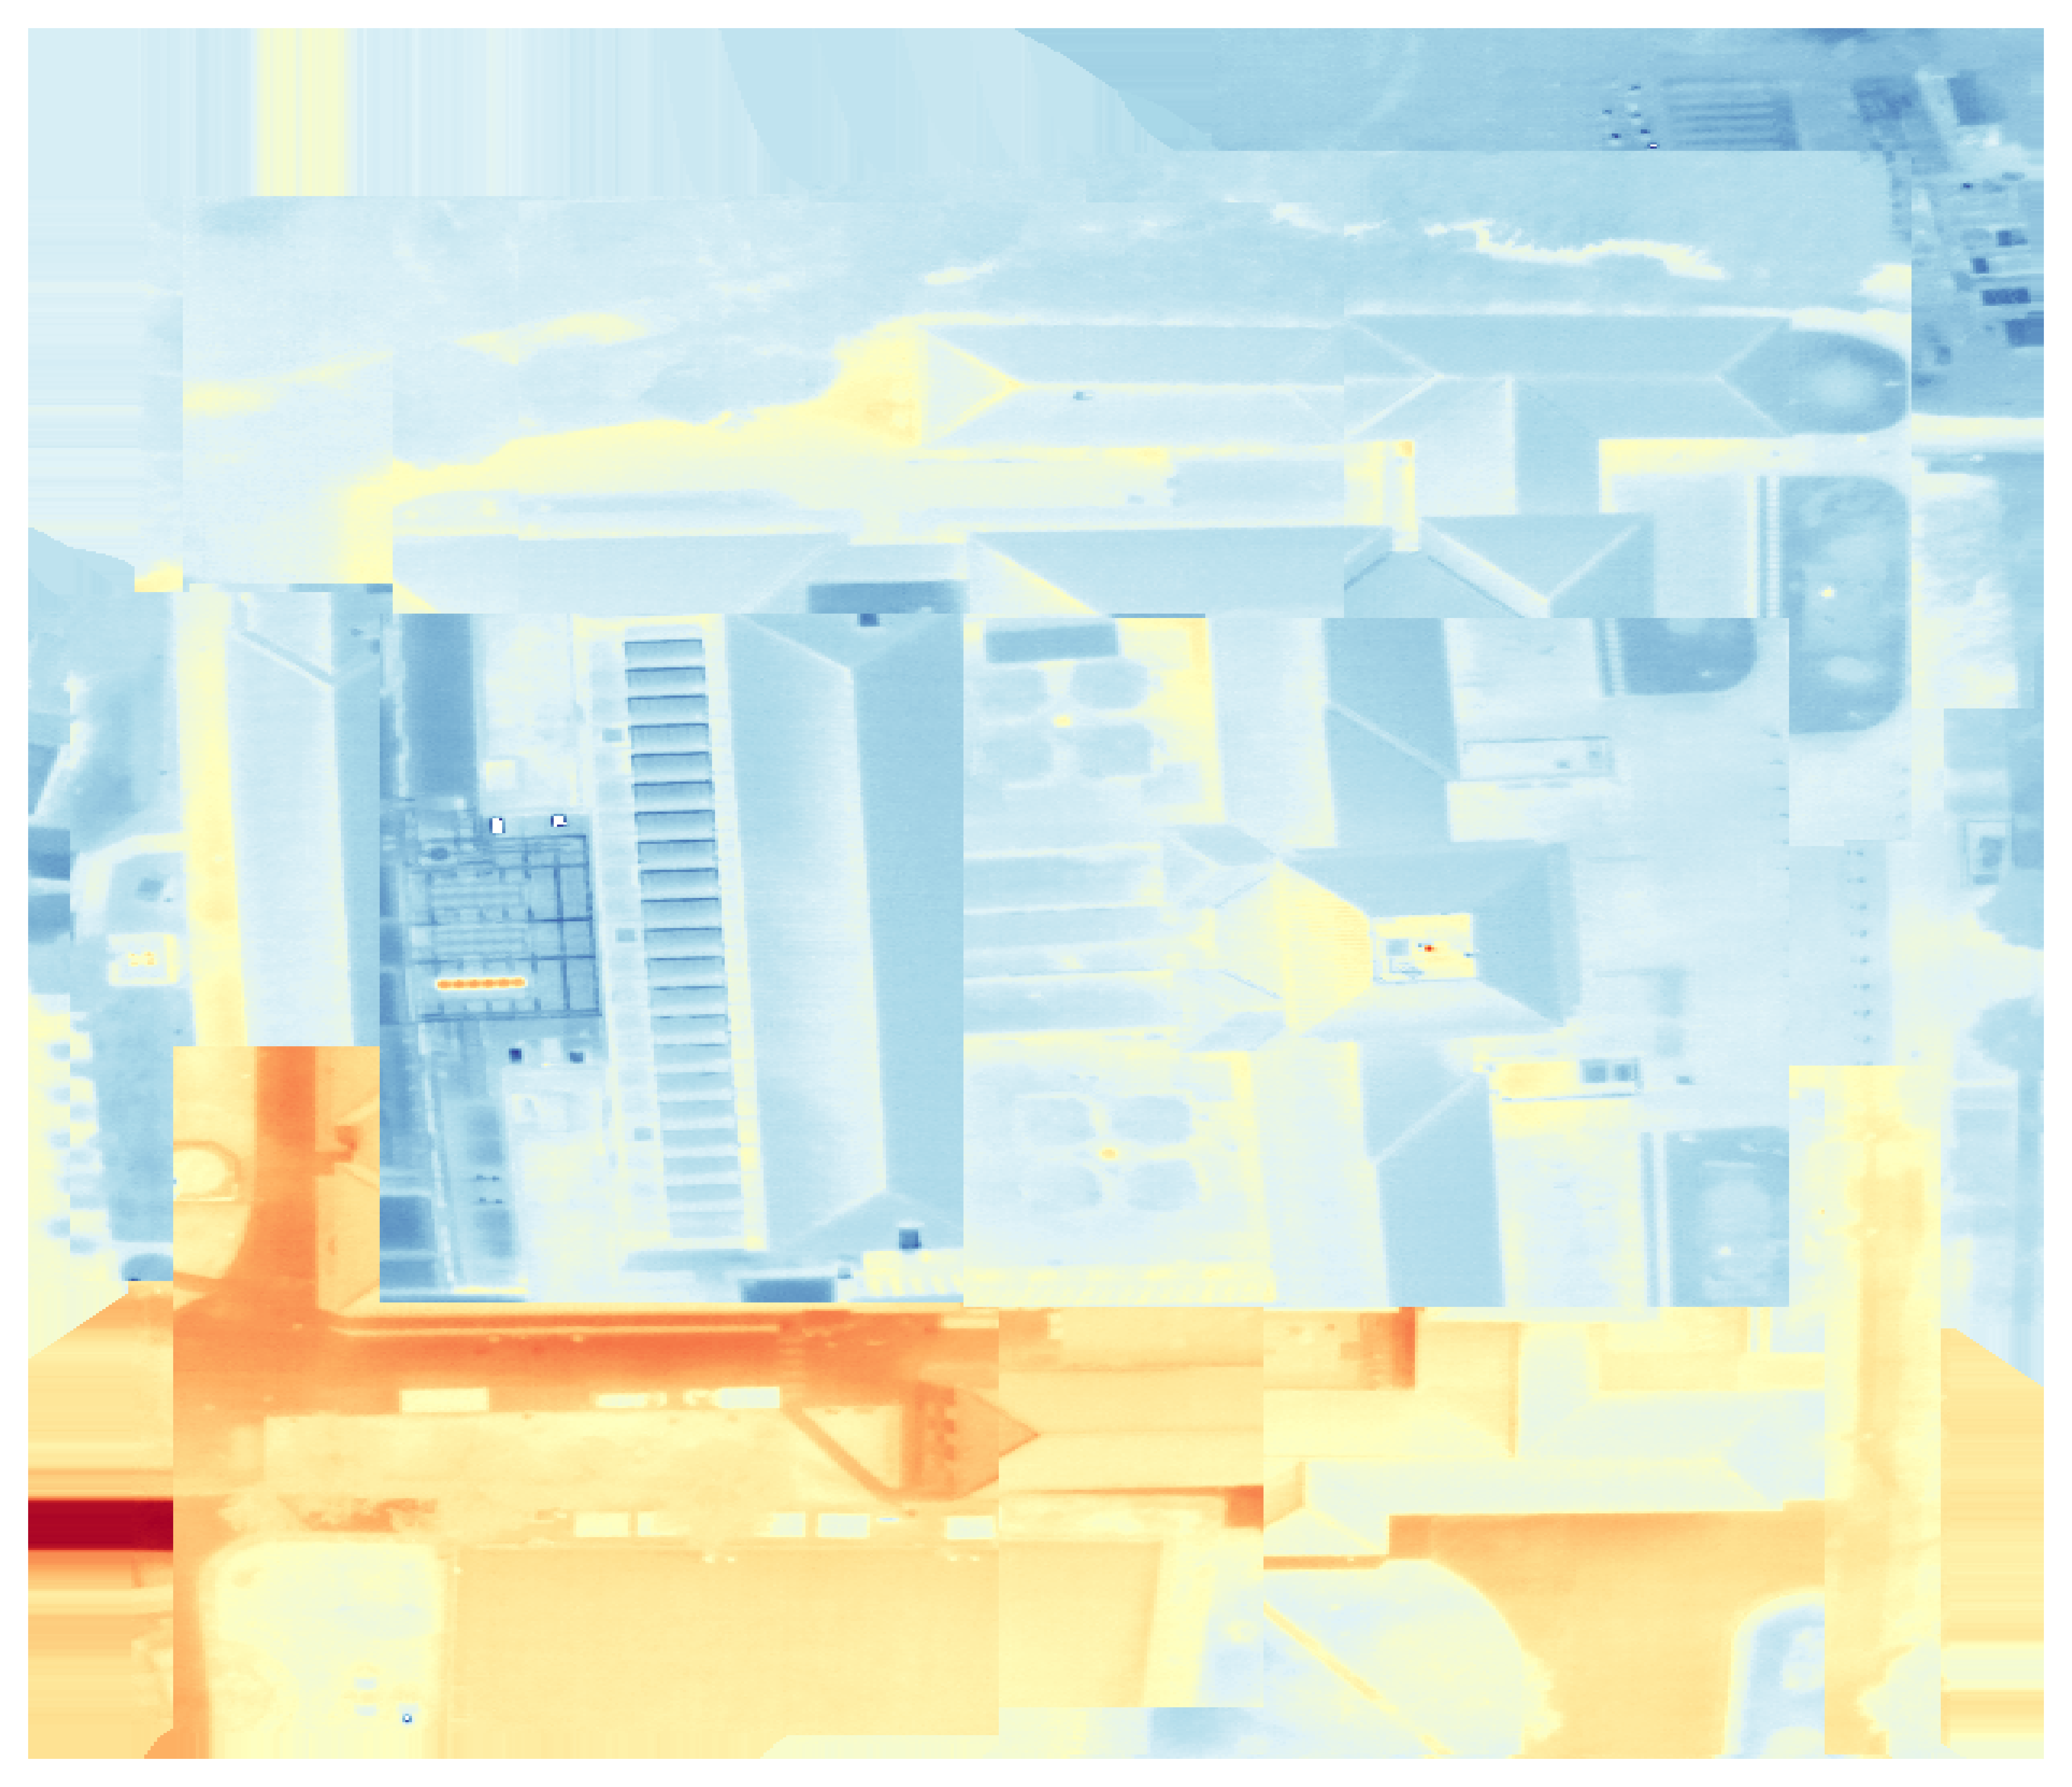

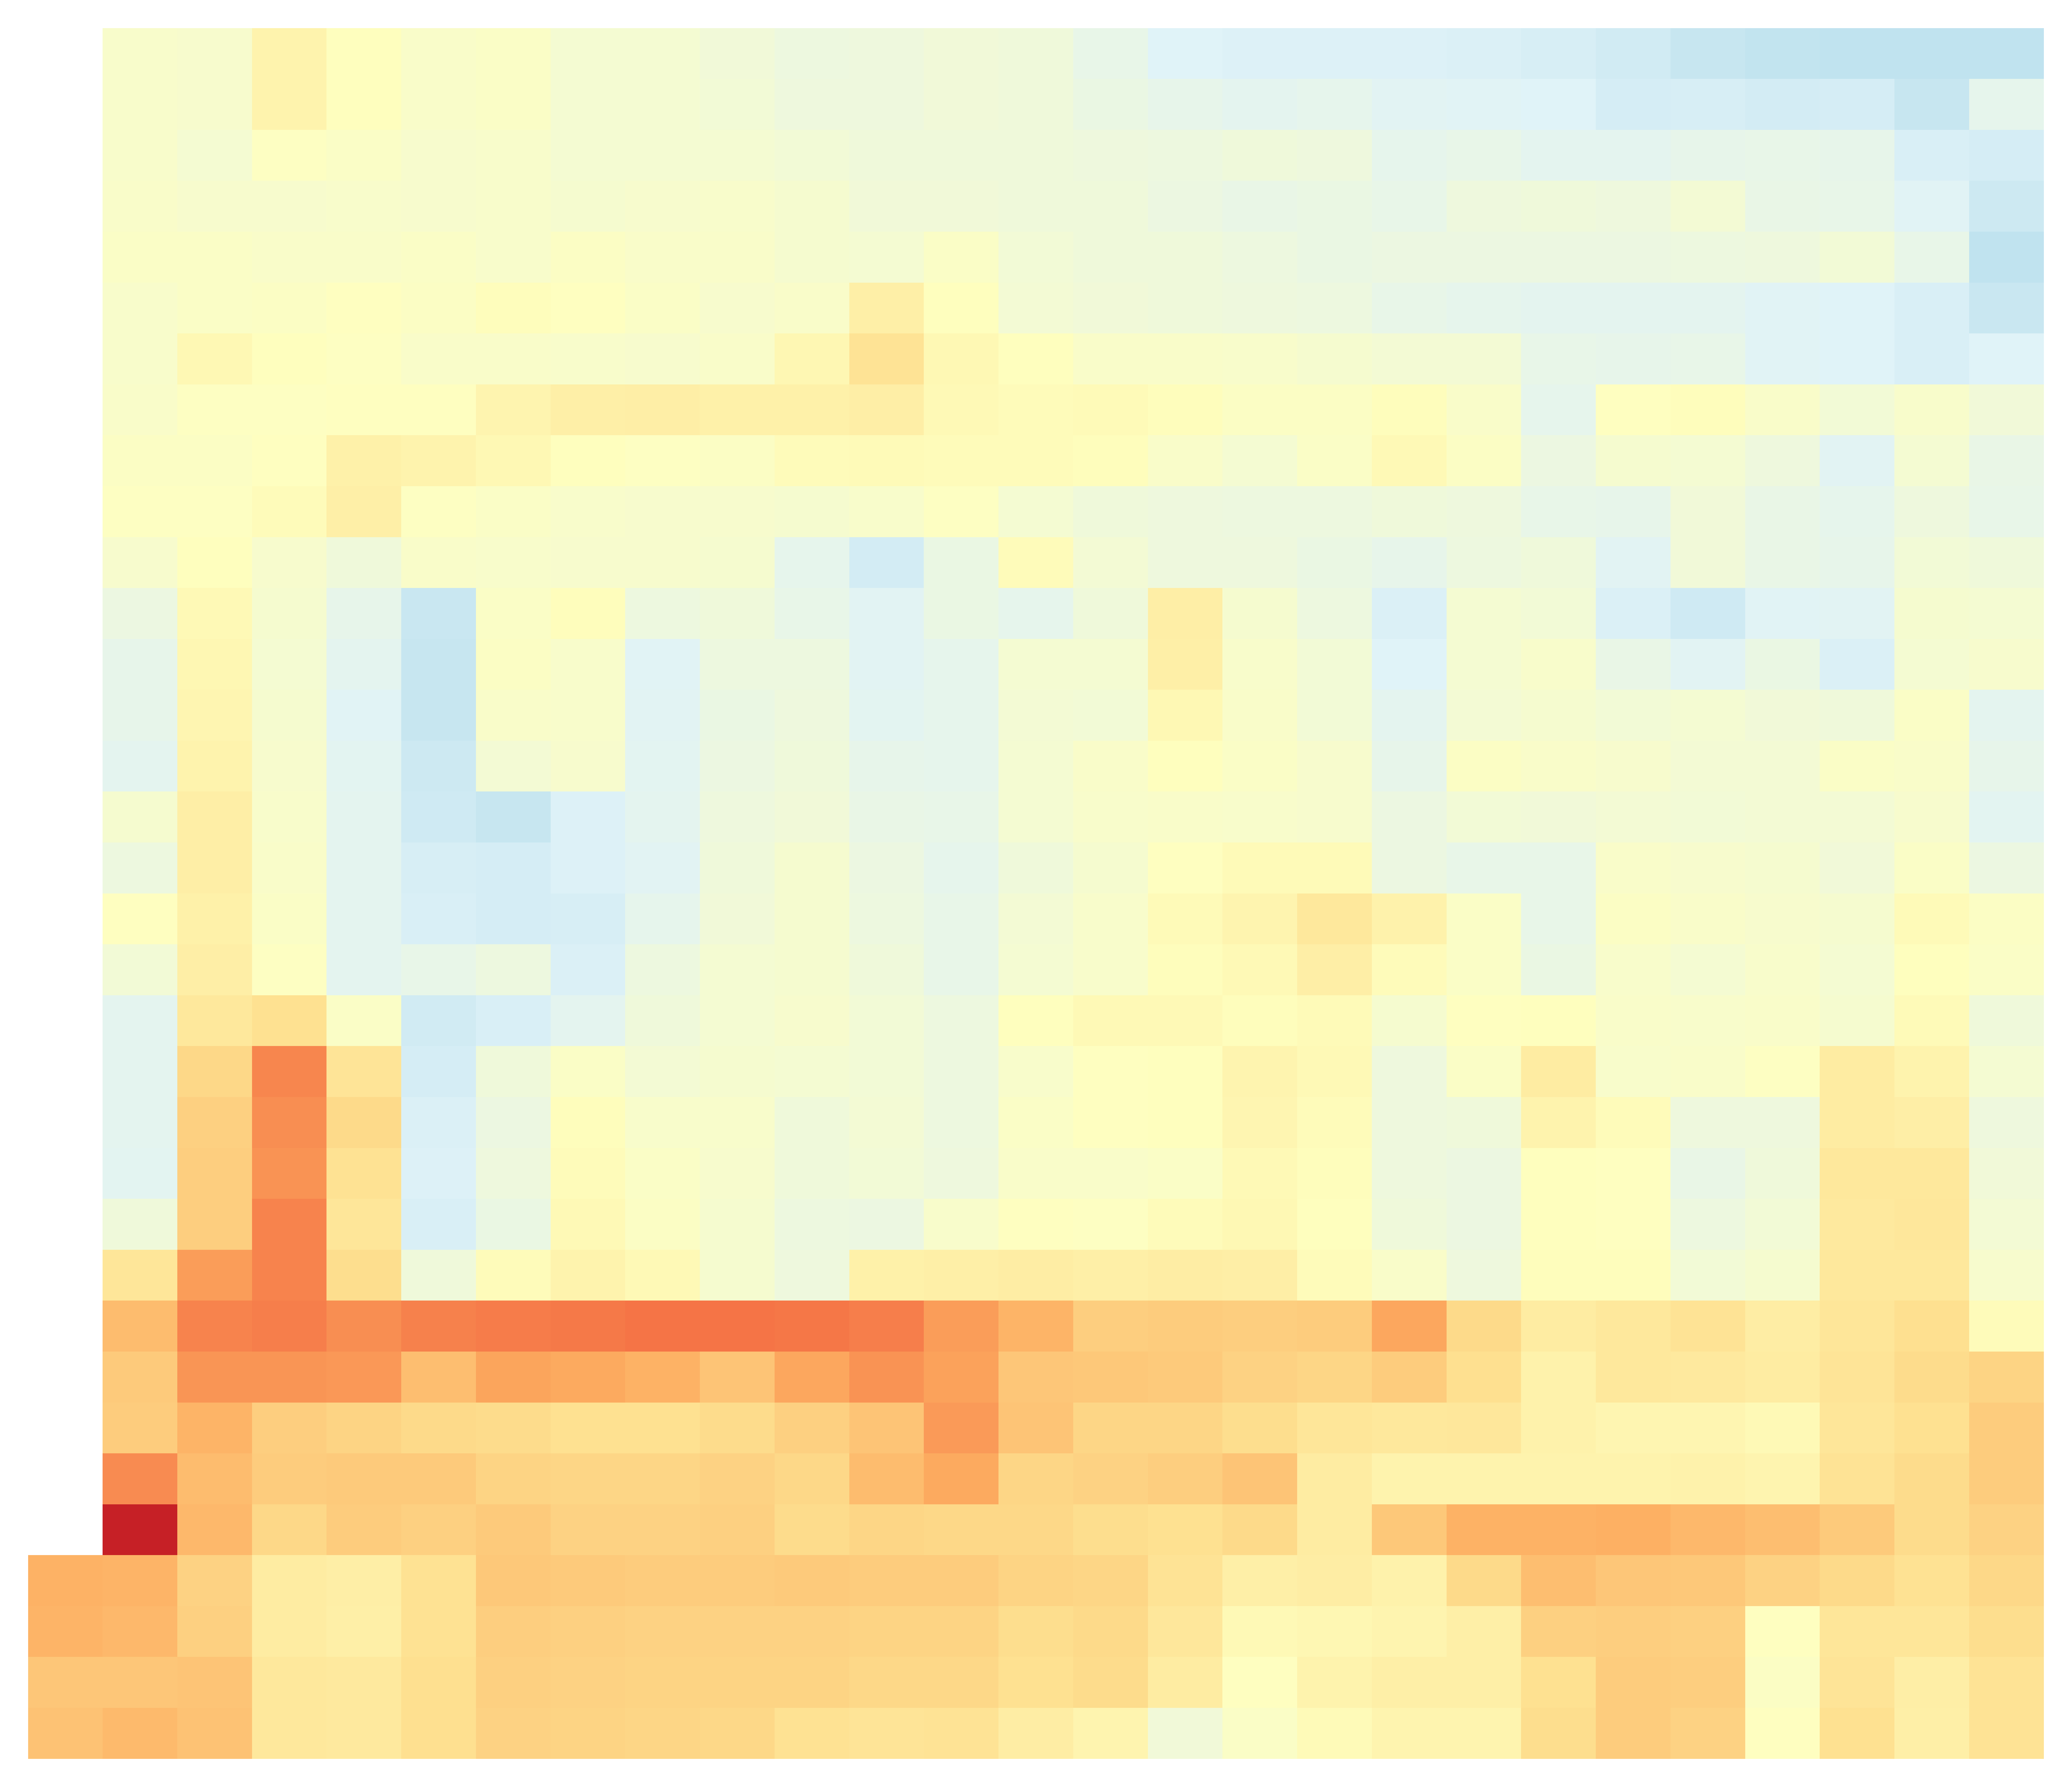

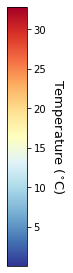

In [15]:
# Save as .kmz file
inputCoords = np.array([[0.106680, 0.108845],[52.204120, 52.204950]])
conv = np.array(myProj([extent[3], extent[2]], [extent[1], extent[0]], inverse=True)) if inputCoords is not False else inputCoords
cs, single = plot_kml(xygrid, conv, outName+'_xymerge', 1024*10, rot=90)
_, ds = plot_kml(hf.downsample_arr(xygrid,pxSize,resolution), conv, outName+'_ds_xymerge', 1024*10, rot=90, scale=xygrid)
plot_kml_legend(cs, outName+'_xylegend')
plot_kml_path(idf, conv, outName+'_xypath', 1024*10)
pl.make_kml(conv, figs=[outName+'_xymerge.png', outName+'_ds_xymerge.png', outName+'_xypath.png'], 
            colorbar=outName+'_xylegend.png', kmzfile=outName+'xymerge_thermal.kmz',
            description=str(resolution)+'m resolution thermal imagery', name='Satellite resolution')    

In [20]:
pl.save_to_csv(ds, single, conv, pxSize, resolution, outName+'_xymerge')

Lossy conversion from float64 to uint8. Range [128.6450969565037, 222.43562802469813]. Convert image to uint8 prior to saving to suppress this warning.
  0%|          | 0/10 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [128.6450969565037, 222.43562802469813]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [125.11406410527556, 222.72377836766435]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [128.6450969565037, 222.43562802469813]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [126.29346531021254, 225.4549754591872]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [128.6450969565037, 222.43562802469813]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [12

Raw matches (Brute force): 72
0.0
Images 0 and 1, poor matching
Raw matches (Brute force): 55
61.007841606924586
Images 0 and 2, poor matching
Raw matches (Brute force): 42
38.69736327507405
Images 0 and 3, poor matching
Raw matches (Brute force): 46
58.42686662925418
Images 0 and 4 merged.
Raw matches (Brute force): 109
nan
Images 4 and 5, poor matching
Raw matches (Brute force): 88
42.473378112737734
Images 4 and 6, poor matching
Raw matches (Brute force): 66


Lossy conversion from float64 to uint8. Range [125.28269713251333, 232.02129809633394]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [125.11406410527556, 233.1567137189676]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████  | 8/10 [00:00<00:00, 29.78it/s]Lossy conversion from float64 to uint8. Range [125.28269713251333, 232.02129809633394]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [125.28269713251333, 222.14735214301362]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [125.28269713251333, 232.02129809633394]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [123.42502367882362, 223.44360602918687]. Convert image to uint8 prior to saving to suppress this warning.
100%|██████████| 10/10 [00:00<00:00, 

32.1746045296158
Images 4 and 7 merged.
Raw matches (Brute force): 121
36.671201053522964
Images 7 and 8, poor matching
Raw matches (Brute force): 109
53.29656928113108
Images 7 and 9, poor matching
Raw matches (Brute force): 87
33.971502110742904
Images 7 and 10 merged.


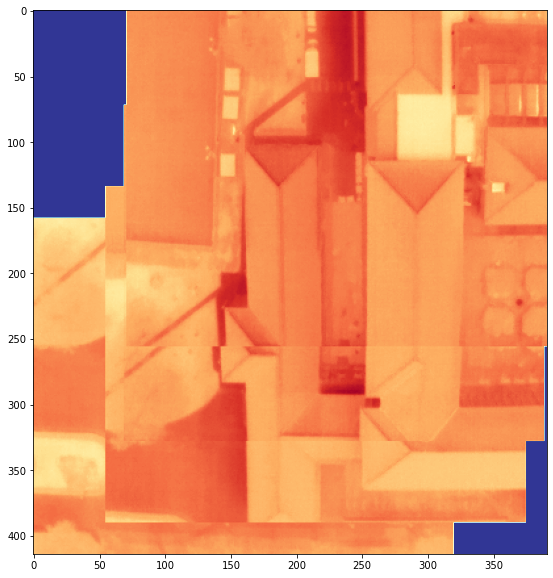

In [28]:
# Multi-image stitching
# Setup variables
if 'result' in globals(): del(result)
feature_extractor, feature_matching = 'orb', 'bf'
tempfiles = ['temp0.jpg','temp1.jpg']
start, end, step = 0, 10, 1
tmin, tmax = -10, 40
imgPath='imgPath'
#xmin, xmax, ymin, ymax = 0,0,0,0

def initialise_vars(idf, start, xq, yq, tmin, tmax, path='imgPath'):
    prev = start
    single = ((hf.img_to_arr(idf.iloc[start][path], xq=xq, yq=yq)-tmin)*255/tmax)
    imageio.imwrite(tempfiles[0],np.dstack((single,single,single)))
    prevImg = np.dstack((single,single,single)).astype(np.uint8)
    totalBox=[prevImg.shape[0], prevImg.shape[1]]
    prevBox=[0,prevImg.shape[0],0,prevImg.shape[1]]
    return prev, single, prevImg, totalBox, prevBox

prev, single, prevImg, totalBox, prevBox = initialise_vars(idf, start, xq, yq, tmin, tmax, path=imgPath)

for imgNum in tqdm(np.arange(start+step if start < end else start-step, end+1, step if start < end else -step)):
    if imgNum in skips: continue # Skip iteration if img in skips
    arrs = [hf.img_to_arr(idf.iloc[i][imgPath], xq=xq, yq=yq) for i in [prev, imgNum]]

    for i, val in enumerate(tempfiles): 
        single = ((arrs[i]+10)*255/40)
        imageio.imwrite(val,np.dstack((single,single,single)))
    # Read images - Make sure that the train image is the image that will be transformed
    trainImg, queryImg = [imageio.imread(i) for i in tempfiles]
    #for i in tempfiles: os.remove(i)
    # Opencv defines the color channel in the order BGR - transform it to RGB to be compatible to matplotlib
    trainImg_gray, queryImg_gray = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in [trainImg, queryImg]]

    # Detect the keypoints and features on both images
    kpsA, featuresA = st.detectAndDescribe(trainImg_gray, method=feature_extractor)
    kpsB, featuresB = st.detectAndDescribe(queryImg_gray, method=feature_extractor)

    # Link  the identified features between images
    if feature_matching == 'bf':
        matches = st.matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    elif feature_matching == 'knn':
        matches = st.matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)

    # Potential to improve by filtering out matches that are not in same direction of travel as drone
    ma = np.array([kpsA[j].pt for j in [i.queryIdx for i in matches]])
    mb = np.array([kpsB[j].pt for j in [i.trainIdx for i in matches]])

    # Filter by only matches in direction of travel
    xmov, ymov = idf.iloc[imgNum]['xc']-idf.iloc[prev]['xc'], idf.iloc[imgNum]['yc']-idf.iloc[prev]['yc']
    bothMov = 2
    if abs(xmov) < bothMov/2 and abs(ymov) < bothMov/2:
        mam, mbm = ma, mb
    else: 
        if abs(xmov) > abs(ymov):
            if xmov < 0:
                mam, mbm = ma[[ma[i,0]>mb[i,0] for i in range(len(ma))]], mb[[ma[i,0]>mb[i,0] for i in range(len(ma))]]
            else: mam, mbm = ma[[ma[i,0]>mb[i,0] for i in range(len(ma))]], mb[[ma[i,0]>mb[i,0] for i in range(len(ma))]]
        else:
            if ymov < 0:
                mam, mbm = ma[[ma[i,1]<mb[i,1] for i in range(len(ma))]], mb[[ma[i,1]<mb[i,1] for i in range(len(ma))]]
            else: mam, mbm = ma[[ma[i,1]>mb[i,1] for i in range(len(ma))]], mb[[ma[i,1]>mb[i,1] for i in range(len(ma))]]

    diff = np.median(mam-mbm, axis=0).astype(int)
  
    #------------------#    
    print(np.std(mam-mbm, axis=0).mean())
    if len(mam) > 10 and np.std(mam-mbm, axis=0).mean() < 60:
        # Work out new positions
        newBox=[int(np.round(prevBox[0]+diff[1])), int(np.round(prevBox[1]+diff[1])), int(np.round(prevBox[2]+diff[0])),int(np.round(prevBox[3]+diff[0]))] # New box position before adjustment for expanding total box

        pos = [0,0] # Position for previously merged images
        modBox = [0,0,0,0] # Position for new image
        # If bounds on axis 0 go beyond total
        if newBox[0]<0:
            xmin = imgNum
            totalBox[0]+=abs(newBox[0])
            modBox[1] = newBox[1]-newBox[0]
            modBox[0] = 0
            pos[0] = abs(newBox[0])
        elif newBox[1] > totalBox[0]:
            xmax=imgNum
            totalBox[0]=newBox[1]
            modBox[1] = newBox[1]
            modBox[0] = newBox[0]
            pos[0] = 0
        else: modBox[0], modBox[1], pos[0] = newBox[0], newBox[1], 0
        # If bounds on axis 1 go beyond total
        if newBox[2]<0:
            ymin=imgNum
            totalBox[1]+=abs(newBox[2])
            modBox[3] = newBox[3]-newBox[2]
            modBox[2] = 0
            pos[1] = abs(newBox[2])
        elif newBox[3] > totalBox[1]:
            ymax=imgNum
            totalBox[1] = newBox[3]
            modBox[3] = newBox[3]
            modBox[2] = newBox[2]
            pos[1] = 0
        else: modBox[2], modBox[3], pos[1] = newBox[2], newBox[3], 0    
        prevBox = modBox  
        
        single = (arrs[1]+10)*255/40
        queryImg = np.dstack((single,single,single)).astype(np.uint8)
        result = np.zeros([totalBox[0],totalBox[1],3])
        result[pos[0]:pos[0]+prevImg.shape[0],pos[1]:pos[1]+prevImg.shape[1],:] = prevImg
        result[modBox[0]:modBox[1], modBox[2]:modBox[3],:] = queryImg
        print('Images {} and {} merged.'.format(str(prev),str(imgNum)))
        prev=imgNum
        prevImg = result
    else: print('Images {} and {}, poor matching'.format(str(prev),str(imgNum)))
    
    
fig = plt.figure(figsize=(20,10))
plt.imshow(result.mean(axis=2),cmap=cmap)

In [ ]:
# Save as kmz
inputCoords = True
userInputCoords = np.array([[0.106680, 0.108845],[52.204120, 52.204950]])
pixels = 1024 * 10
cmap = colorbrewer.get_map('RdYlBu', 'diverging', 11, reverse=True).mpl_colormap
if inputCoords: conv = userInputCoords
else: conv = np.array(myProj([idf.iloc[xmin]['yc']-pxSize*(np.floor(queryImg.shape[0]/2)+0.5), idf.iloc[xmax]['yc']+pxSize*(np.floor(queryImg.shape[0]/2)+0.5)],
                       [idf.iloc[ymin]['xc']-pxSize*(np.floor(queryImg.shape[1]/2)+0.5), idf.iloc[ymax]['xc']+pxSize*(np.floor(queryImg.shape[1]/2)+0.5)], inverse=True))
fig, ax = hf.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                         pixels=pixels)

rot = ndimage.rotate(result.mean(axis=2), 90)
single = np.ma.masked_where(rot < 1e-1, rot)/255*40-10
cs = ax.imshow(single,extent=(conv[0].min(),conv[0].max(),conv[1].min(),conv[1].max()), cmap=cmap, vmin=single.min(),vmax=single.max())
ax.set_axis_off()
fig.savefig('original0-25.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
resolution = 6
fig, ax = hf.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                         pixels=pixels)
#ds = hf.downsample_arr(single,pxSize,resolution)
#single = rot/255*50-10
ds = np.ma.masked_where(abs(hf.downsample_arr(single.filled(),pxSize,resolution)) > 1e3, hf.downsample_arr(single,pxSize,resolution))
cs = ax.imshow(ds,extent=(conv[0].min(),conv[0].max(),conv[1].min(),conv[1].max()), cmap=cmap, vmin=single.min(),vmax=single.max())
ax.set_axis_off()
fig.savefig('downsample0-25.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig = plt.figure(figsize=(1.0, 4.0))
ax = fig.add_axes([0.07, 0.05, 0.27, 0.9])
cb = fig.colorbar(cs, cax=ax)
cb.set_label('Temperature ($^{\circ}$C)', rotation=-90, color='k', labelpad=20, fontsize=13)
fig.tight_layout()
fig.savefig('legend.png', format='png', bbox_inches = 'tight', pad_inches = 0.2) 

In [ ]:
#Flight Path
stop = 25
x, y = idf.longitude[:stop], idf.latitude[:stop]
fig, ax = hf.gearth_fig(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
                         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
                         pixels=pixels)
ax.plot(x,y,'k-',linewidth=2,label='raw')
ax.set_axis_off()
fig.savefig('path0-25.png', transparent=True, format='png', bbox_inches = 'tight', pad_inches = 0)

In [ ]:
hf.make_kml(llcrnrlon=conv[0].min(), llcrnrlat=conv[1].min(),
         urcrnrlon=conv[0].max(), urcrnrlat=conv[1].max(),
         figs=['overlay1.png', 'overlay2.png','path.png'], colorbar='legend.png',
         kmzfile='stitch_thermal.kmz', description=str(resolution)+'m resolution thermal imagery', name='Satellite resolution')

In [ ]:
# Save as .csv file
ds_arr = ds.shape
ptslon = np.linspace(conv[0].min(),conv[0].max(),ds_arr[1]+1)[:-1]
ptslon += (ptslon[1]-ptslon[0])/2
ptslat = np.linspace(conv[1].min(),conv[1].max(),ds_arr[0]+1)[:-1]
ptslat += (ptslat[1]-ptslat[0])/2
lonm, latm = np.meshgrid(ptslon,ptslat)

import pandas as pd
ds_q = int(np.floor(resolution/pxSize))
arr = np.round(single[:-(single.shape[0] % ds_q),:-(single.shape[1] % ds_q)]).astype(int)
most=np.zeros([len(range(0,arr.shape[0]-ds_q,ds_q))+1, len(range(0,arr.shape[1]-ds_q,ds_q))+1])
for i in range(0,arr.shape[0],ds_q):
    for j in range(0,arr.shape[1],ds_q):
        most[int(i/ds_q),int(j/ds_q)] = Counter(arr[i:i+ds_q,j:j+ds_q].reshape(1,-1).tolist()[0]).most_common(1)[0][0]
        
tdf = pd.DataFrame(np.concatenate([np.flip(latm.reshape(-1,1)), lonm.reshape(-1,1), ds.reshape(-1,1), most.reshape(-1,1)], axis=1), columns=['Latitude', 'Longitude', '6m T(C)', '0.27cm T(C)'])
filt = tdf[ds.mask.reshape(-1,1) == False]
filt.to_csv('plots/stitch_temps.csv', index_label='UID')